# Analyzing NYC High School Data
## Compiled By: Dana Hagist

Over the last three Dataquest missions, I explored relationships between SAT scores and demographic factors in New York City public schools. For a brief bit of background, the SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each of which is worth a maximum of 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on student SAT scores by high school, along with additional demographic data sets. Over the last three missions, I combined the following data sets into a single, clean pandas dataframe:
- SAT scores by school - SAT scores for each high school in New York City
School attendance - Attendance information for each school in New York City
- Class size - Information on class size for each school
- AP test results - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- Graduation outcomes - The percentage of students who graduated, and other outcome information
- Demographics - Demographic information for each school
- School survey - Surveys of parents, teachers, and students at each school

New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. For example, if certain racial groups consistently perform better on the SAT, we would have some evidence that the SAT is unfair.

In the last mission, I began performing some analysis. I'll extend that analysis in this mission. Dataquest has included the code to read in all of the data, combine it, and create correlations in the notebook. 

The dataframe "combined" contains all of the data I'll be using in my analysis.

In [2]:
import pandas
import numpy
import re
import matplotlib
import matplotlib.pyplot as plt

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [6]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [7]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [8]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [9]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [10]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [11]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Print Survey Fields

In [12]:
print(survey_fields)

['DBN', 'rr_s', 'rr_t', 'rr_p', 'N_s', 'N_t', 'N_p', 'saf_p_11', 'com_p_11', 'eng_p_11', 'aca_p_11', 'saf_t_11', 'com_t_11', 'eng_t_10', 'aca_t_11', 'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11', 'saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11']


Task: 

- Set up matplotlib to work in Jupyter notebook.
- There are several fields in combined that originally came from a survey of parents, teachers, and students. Make a bar plot of the correlations between these fields and sat_score.
    - You can find a list of the fields in the survey_fields variable in the notebook.

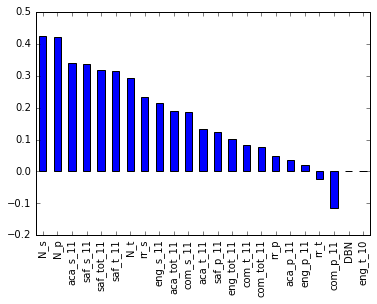

In [13]:
# Solution: 
%matplotlib inline

correlated=combined.corr()["sat_score"][survey_fields]
correlated.sort_values(inplace=True, ascending=False)
correlated.plot.bar()

Task: 
   - Consult the data dictionary that's part of the zip file you can download from the City of New York's website at https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8
    - Did you find any surprising correlations?

- Write up your results in a Markdown cell.

Solution: 

The two fields that have the highest (positive) correlation with SAT scores is the number of student and parent respondents, respectively.  This makes sense based on the fact that if parents and students are highly involved with their school, they likely tend to take school more seriously and perform better academically.

The next two fields with the largest postive correlation with SAT scores are 'Safety and Respect score based on student responses' and 'Academic expectations score based on student responses.'  These also make sesnse as they indicate that students both feel safe and respected, and that the expectations of them are high.  These are likely students that go to some of the highest ranked schools and understand that scholastic achievement is very important at their school.

The number of teacher respondents and rate of student responses also appear to have strong correlations with SAT scores.  

The measures having lower correlations with SAT scores appear to be related to either communication or engagement.

### Understanding Student's Perception of Safety

On the last screen, you may have noticed that saf_t_11 and saf_s_11, which measure how teachers and students perceive safety at school, correlated highly with sat_score. On this screen, we'll dig into this relationship a bit more, and try to figure out which schools have low safety scores.


Task: Investigate safety scores.
- Make a scatter plot of the saf_s_11 column vs. the sat_score in combined.
- Write up your conclusions about safety and SAT scores in a Markdown cell.

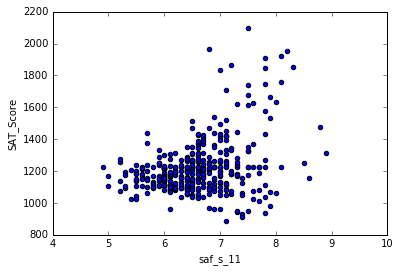

In [15]:
# Solution: 
plt.scatter(combined['saf_s_11'],combined['sat_score'])
plt.xlabel('saf_s_11')
plt.ylabel('SAT_Score')

Looking at the above scatterplot, it does appear that there is a positive correlation between perceived safety and SAT score.  However, there does appear to be a good amount of noise in the correlation.  For example, there are a large number of SAT scores between 1100 and 1300 regardless of safety perception.  However, some of the schools with the highest SAT achievement do appear to also have high safety measures.

Task: Map out safety scores.
- Compute the average safety score for each district.
- Make a map that shows safety scores by district.
- Write up your conclusions about safety by geographic area in a Markdown cell. - You may want to read up on the boroughs of New York City here: https://www.nycgo.com/boroughs-neighborhoods

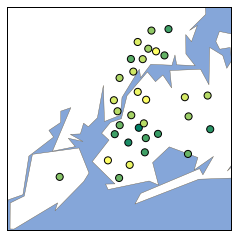

In [17]:
# Solution: 
from mpl_toolkits.basemap import Basemap;

districts = combined.groupby('school_dist')
districts = districts.agg(numpy.mean)

districts.reset_index(inplace=True)

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()

m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True,c=districts["saf_s_11"], cmap="summer")
plt.show()

It appears based on the map above that the highest perceived safety is in the heart of Brooklyn.  When considering parts of Manhattan, Queens, and the Bronx, the perceived safety scores appear to be lower.

### Analyzing Racial Differences in SAT Scores

There are a few columns that indicate the percentage of each race at a given school:
- white_per
- asian_per
- black_per
- hispanic_per

By plotting out the correlations between these columns and sat_score, we can determine whether there are any racial differences in SAT performance.

Task: Investigate racial differences in SAT scores.
- Make a bar plot of the correlations between the columns above and sat_score.
- Write up a Markdown cell containing your findings. Are there any unexpected correlations?

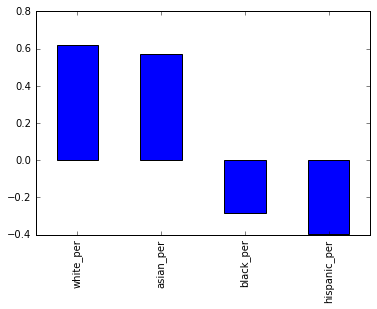

In [18]:
# Solution: 
fields = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
correlated_pers= combined.corr()["sat_score"][fields]
correlated_pers.sort_values(inplace=True, ascending=False)
correlated_pers.plot.bar()

The above bar chart suggests that population of white and asian students has a positive correlation with SAT scores, while population of black and hispanic students are negatively correlated with SAT scores.  I would say based on research that has been conducted in the past regarding educational opportunity, violence, and other factors impacting minorities, these results are not particularly unexpected.

Task: Explore schools with low SAT scores and high values for hispanic_per.
- Make a scatter plot of hispanic_per vs. sat_score.
- What does the scatter plot show? Record any interesting observsations in a Markdown cell.

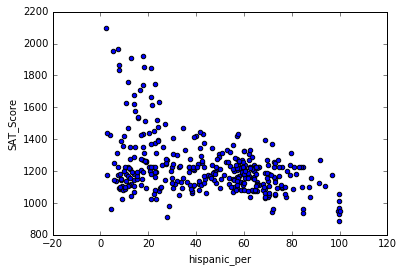

In [20]:
# Solution: 
combined.plot.scatter('hispanic_per','sat_score')
plt.xlabel('hispanic_per')
plt.ylabel('SAT_Score')

Based on the scatter plot above, the negative correlation between hispanic percentage and SAT score is evident.  However, we can see that there is a large band again of SAT scores between 1100 and 1300 regardless of the hispanic percentage.

Task: Research any schools with a hispanic_per greater than 95%.
- Find the school names in the data.
- Use Wikipedia and Google to research the schools by name.
- Is there anything interesting about these particular schools? Record your findings in a Markdown cell.

In [21]:
# Solution: 
high_hisp = combined[combined['hispanic_per']>95]
print(high_hisp['school_name'])

44                         Manhattan Bridges High School
82      Washington Heights Expeditionary Learning School
89     Gregorio Luperon High School for Science and M...
125                  Academy for Language and Technology
141                International School for Liberal Arts
176     Pan American International High School at Monroe
253                            Multicultural High School
286               Pan American International High School
Name: school_name, dtype: object


From a search of these schools on Wikipedia, it appears that these schools are geared toward providing opportunity to minority students.  For example, Washington Heights Expeditionary Learning School is a predominantly Dominican school that encourage university admissions from very early ages.

Task: Research any schools with a hispanic_per less than 10% and an average SAT score greater than 1800.
- Find the school names in the data.
- Use Wikipedia and Google to research the schools by name.
- Is there anything interesting about these particular schools? Record your findings in a Markdown cell.

In [22]:
# Solution:
print(combined[['hispanic_per','sat_score']].head())
low_hisp = combined[combined['hispanic_per']<10]
print(low_hisp['school_name'])

   hispanic_per  sat_score
0          53.8     1122.0
1          45.9     1172.0
2          55.4     1149.0
3          56.9     1207.0
4          14.2     1621.0
37                                Stuyvesant High School
46       High School for Dual Language and Asian Studies
151                         Bronx High School of Science
187                       Brooklyn Technical High School
192                          Bedford Academy High School
194                            Benjamin Banneker Academy
220                           Boys and Girls High School
223    Academy for College Preparation and Career Exp...
226               The High School for Global Citizenship
227                         School for Human Rights, The
228                  School for Democracy and Leadership
229    High School for Youth and Community Developmen...
230        High School for Service & Learning at Erasmus
231    Science, Technology and Research Early College...
235              Medgar Evers College Pr

Based on a search of the schools listed above, these are some of the most academically rigorous, "specialized" schools in New York City.  Most of these schools are preparatory programs that specialize in STEM (Science, Technology, Engineering and Mathematics).

### Analysis of Gender and SAT Scores

There are two columns that indicate the percentage of each gender at a school:
- male_per
- female_per

We can plot out the correlations between each percentage and sat_score.

Text: Investigate gender differences in SAT scores.
- Make a bar plot of the correlations between the columns above and sat_score.
- Record your findings in a Markdown cell. Are there any unexpected correlations?

   male_per  female_per  sat_score
0      61.4        38.6     1122.0
1      57.4        42.6     1172.0
2      54.7        45.3     1149.0
3      46.3        53.7     1207.0
4      49.2        50.8     1621.0


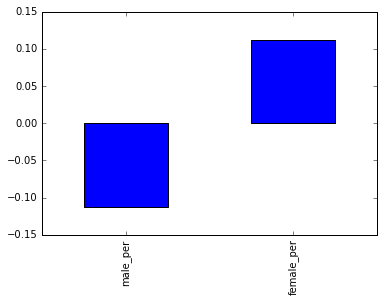

In [23]:
# Solution: 
print(combined[['male_per','female_per','sat_score']].head())

gender_pct = ["male_per", "female_per"]
combined.corr()["sat_score"][gender_pct].plot.bar()

Based on the bar chart above, it appears that female percentage is weakly positively correlated with SAT scores.  This means that a higher female percentage is generally associated with higher SAT scores.  Conversely, male percentage is weakly negatively correlated with SAT scores.  This means a higher percentage of males is associated with lower SAT scores.

Task: Investigate schools with high SAT scores and a high female_per.
- Make a scatter plot of female_per vs. sat_score.
- What does the scatter plot show? Record any interesting observations in a Markdown cell.

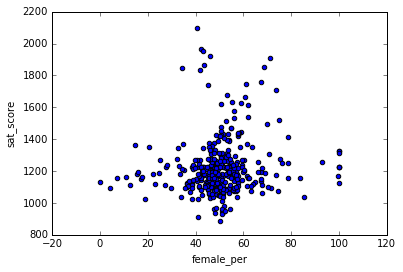

In [24]:
# Solution: 
combined.plot.scatter('female_per','sat_score')

The scatter plot above, reflecting the association between female percentage and sat score indicates a dynamic relationship.  It appears that there are a large set of schools in the average sat score range that do not necessarily relate to gender percentages.  The schools that are all girls or almost all girls tend to fall right in the average SAT score range.  However, there are a number of schools with between 60% and 80% females that have significantly higher SAT scores.  It's also worth noting that most of the schols with over 1600 SAT scores have a somewhat even distribution of males and females.

Task: Research any schools with a female_per greater than 60% and an average SAT score greater than 1700.
- Find the school names in the data.
- Use Wikipedia and Google to research the schools by name.
- Is there anything interesting about these particular schools? Record your findings in a Markdown cell.

In [25]:
# Solution:
high_fem = combined[combined['female_per']>60]
high_fem_sat = high_fem[high_fem['sat_score']>1700]
print(high_fem_sat['school_name'])

5                         Bard High School Early College
26                         Eleanor Roosevelt High School
60                                    Beacon High School
61     Fiorello H. LaGuardia High School of Music & A...
302                          Townsend Harris High School
Name: school_name, dtype: object


Based on an analysis of the schools above, these appear to mostly be college preparatory schools, with a focus on academic rigor.  It would be interesting to understand the propensity of females to attend these schools as compared to their male counterparts.

### Exploring AP Exams and SAT Scores

In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because total_enrollment is highly correlated with sat_score, we don't want to bias our results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

Task: Calculate the percentage of students in each school that took an AP exam.
- Divide the AP Test Takers column by the total_enrollment column.
    - The column name AP Test Takers has a space at the end -- don't forget to add it!
- Assign the result to the ap_per column.
- Investigate the relationship between AP scores and SAT scores.
    - Make a scatter plot of ap_per vs. sat_score.
    - What does the scatter plot show? Record any interesting observations in a Markdown cell.

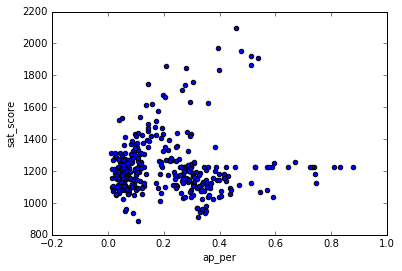

In [27]:
# Solution: 
combined['ap_per'] = combined['AP Test Takers ']/ combined['total_enrollment']
combined.plot.scatter(x='ap_per', y='sat_score')

The plot above suggests another dynamic relationship between ap percentage and sat score.  There appear to be a number of schools that have a heavy emphasis on AP tests, but still sit a little bit over a 1200 sat score average.  Howvever, there are other subset of schools that have almost a linear relationship between sat score and ap percentage.  Further data analysis could review details on the schools that have a high sat score and ap percentage.

### Potential Next Steps:

We've done quite a bit of investigation into relationships between demographics and SAT scores in this guided project. There's still quite a bit of analysis left to do, however. Here are some potential next steps:
- Determing wheter there's a correlation between class size and SAT scores
- Figuring out which neighborhoods have the best schools
    - If we combine this information with a dataset containing property values, we could find the least expensive neighborhoods that have good schools.
- Investigating the differences between parent, teacher, and student responses to surveys.
- Assigning scores to schools based on sat_score and other attributes.



